In [1]:
import sys
packages = [
    '../dataset/',
    '../utils/',
    '../optimizer/',
    '../loss/',
    '../model/'
]
sys.path.extend(packages)
from sklearn.model_selection import KFold
from tqdm import tqdm
from brpnet.model import UNet
from loss import dice_loss, smooth_truncated_loss, compute_loss_list
from adamw_r.cyclic_scheduler import CyclicLRWithRestarts, ReduceMaxLROnRestart
from adamw_r.adamw import AdamW
from ImageProcess.ImgShow import showLineImg
from dataset.PathologyData import PathologyDataSet
import cv2
import torch.nn.functional as F
import time
import torch
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn
from postProcess.post_proc import post_proc
# 首先先对图片进行染色归一化处理
from StainProcess.StainNormalization import normalizeStaining
from ImageProcess.ImageProcess import cv2Bgr2Rgb
from DataUtil import kfold_list
from util import getNowTime,transformImg,extract_patches,reconstruct_from_patches_weightedall,test_extract_patches
import scipy.io as scio
from metrics import get_fast_aji,remap_label
from scipy import ndimage
from skimage.morphology import label



In [11]:
# 先获取真实的数据
# test_same_images = np.load('../dataset/kumarDataset/train/testSameDataSet.npy')
# gt_labels = np.load('../dataset/kumarDataset/labels/labelSameDataSet.npy')
# gt_bounds = np.load('../dataset/kumarDataset/bounds/boundSameDataSet.npy')

# gt_label = gt_labels[0]
# gt_bound = gt_bounds[0]
# showLineImg([gt_label,gt_bound],title=['gt_label','gt_bound'])

# 计算aji
def getfastAji(pred,gt):
    # lbl_dilation = ndimage.morphology.binary_dilation(pred, iterations=1)
    # lbl_dilation_label = label(lbl_dilation)
    # lbl_dilation_label[lbl_dilation_label<10] = 0
    # showLineImg([lbl_dilation_label,gt])
    aji = get_fast_aji(remap_label(gt), remap_label(pred))
    return aji

# 加载数据计算aji
def loadDataCalculateAji():
    filename = ['val_0_pred_model_of_360.npz','val_1_pred_model_of_360.npz','val_2_pred_model_of_360.npz','val_3_pred_model_of_360.npz','val_4_pred_model_of_360.npz',\
    'val_5_pred_model_of_360.npz','val_6_pred_model_of_360.npz','val_7_pred_model_of_360.npz']
    ajiList= []
    for single_file in filename:
        single_file = './test_same/'+single_file
        pred_img = np.load(single_file)
        # img = pred_img['img']
        gt = pred_img['gt']
        pred2 = pred_img['pred2']
        aji = getfastAji(pred2,gt)
        ajiList.append(aji)
    return ajiList


ajiList = loadDataCalculateAji()


print(np.mean(ajiList))
print(np.max(ajiList))
print(np.min(ajiList))



0.5617345962947417
0.6427233747398954
0.4200885293062051


(1000, 1000)


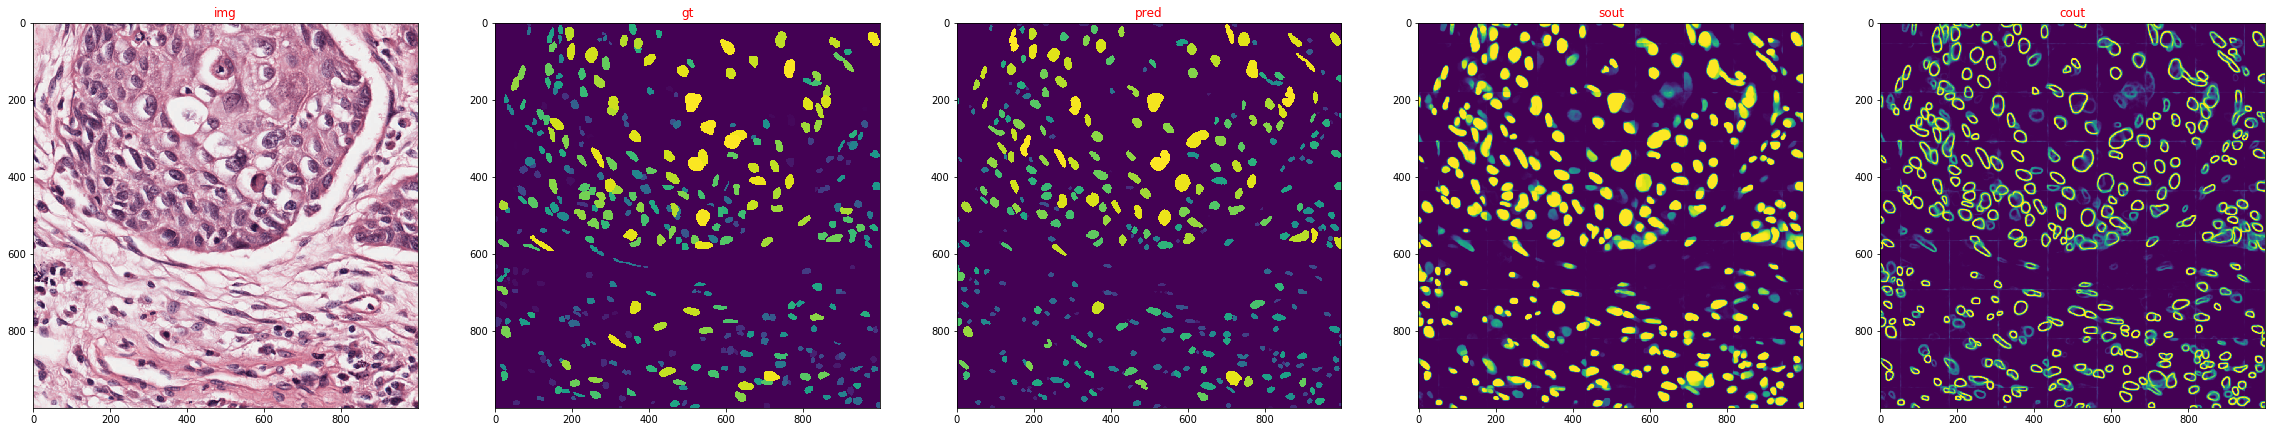

In [29]:

# 根据sout,cout生成实际的标签
# test/test_same/val_1_pred_model_of_360.npz
# test/test_same/val_0_pred_model_of_360.npz
pred_img = np.load('./test_same/val_0_pred_model_of_360.npz')
img = pred_img['img']
sout = pred_img['sout']
cout = pred_img['cout']
gt = pred_img['gt']

pred0 = pred_img['pred0']
pred1 = pred_img['pred1']
pred2 = pred_img['pred2']

showLineImg([img,gt,pred2,sout,cout],title=['img','gt','pred','sout','cout'],figsize=(40,40))
print(sout.shape)




In [64]:
# 膨胀一次之后计算得到的效果更好
def getgestAji(pred,gt):
    lbl_dilation = ndimage.morphology.binary_dilation(pred, iterations=1)
    lbl_dilation_label = label(lbl_dilation)
    lbl_dilation_label[lbl_dilation_label<10] = 0
    # showLineImg([lbl_dilation_label,gt])
    aji = get_fast_aji(remap_label(lbl_dilation_label), remap_label(gt))
    return aji

print(getgestAji(pred2,gt))

0.5769357927858088


In [40]:
# 获取面积最小的点然后去掉
np.unique(gt)








array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [8]:

aji2 = get_fast_aji(remap_label(pred2), remap_label(gt))
print(aji0,aji1,aji2)




0.39678164844478864 0.46551378268667987 0.5274340322350592


0.5419015473125014


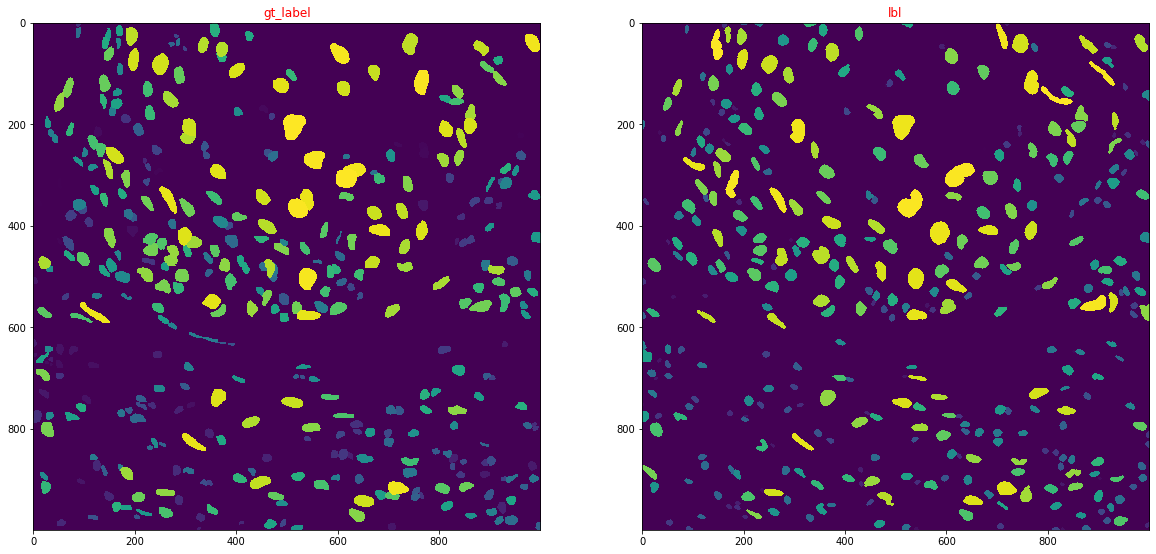

In [6]:
# 进行后处理的相关动作
# img_semantic = post_proc(sout,cutoff=0.5,post_dilation_iter=1)
# img_outline = post_proc(cout,cutoff=0.5,post_dilation_iter=1,post_fill_holes=False)
# 原文里面足作者的代码
lbl = post_proc(sout-cout, post_dilation_iter=2)
aji = get_fast_aji(remap_label(lbl), remap_label(gt_label))
print(aji)
showLineImg([gt_label,lbl],title=['gt_label','lbl'],figsize=(20,20))


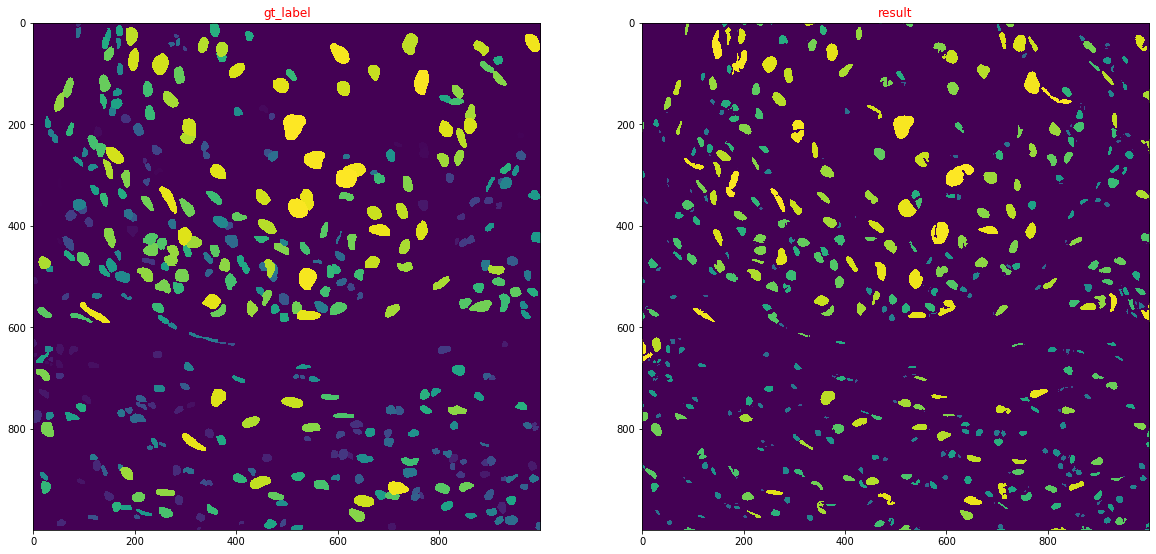

In [9]:
# 我自己的处理方法
img_semantic = post_proc(sout,cutoff=0.5,post_dilation_iter=1)
img_outline = post_proc(cout,cutoff=0.5,post_dilation_iter=1,post_fill_holes=False)
# 
img_semantic[img_semantic != 0] = 1
img_outline[img_outline != 0] = 1
# 将cout腐蚀一点，方便做减法的时候有更多的语义标签被保留
img_erosion = ndimage.morphology.binary_erosion(img_outline,iterations=1)
# 相减操作的时候不要进行膨胀操作
result = post_proc(img_semantic-img_erosion,cutoff_instance_max=0.5,post_dilation_iter=0)
# # #
showLineImg([gt_label,result],title=['gt_label','result'],figsize=(20,20))


In [13]:
print(get_fast_aji(remap_label(result),remap_label(gt_label)))


0.38804179097904945


0.4666141047251373


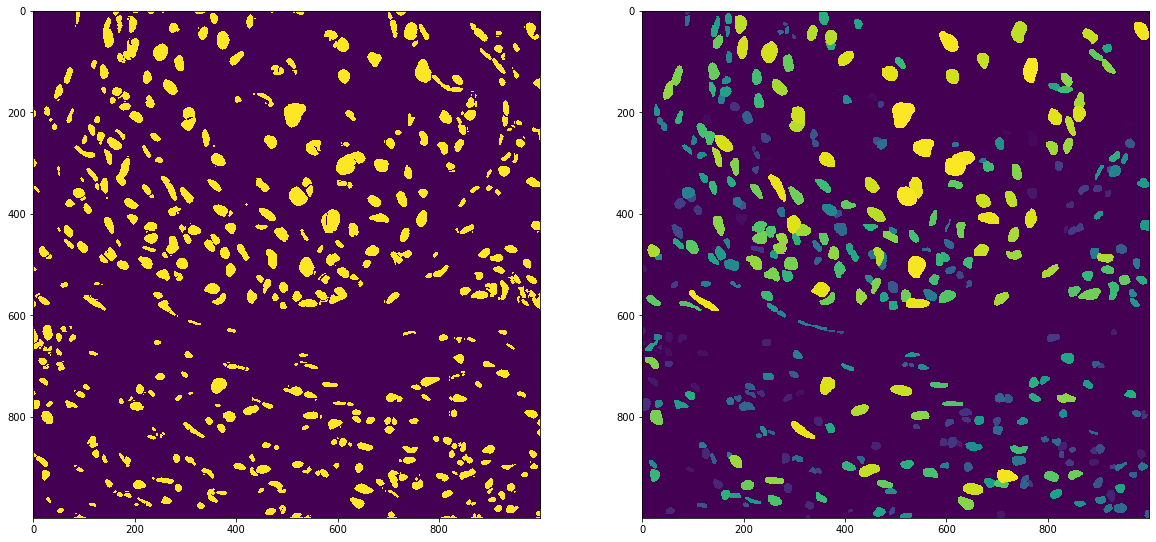

In [12]:
# 经过一次膨胀之后的aji的值变得特别的好
result_dilation = ndimage.morphology.binary_dilation(result, iterations=1)

result_dilation_label = label(result_dilation,connectivity=1)
aji = get_fast_aji(remap_label(result_dilation_label),remap_label(gt_label))
print(aji)
showLineImg([result_dilation,gt_label],figsize=(20,20))

# 下面的代码就不在进行考虑了

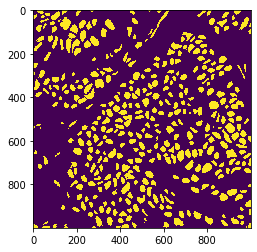

In [6]:

lab_img = label(result, connectivity=1)
lab_img_dilation = ndimage.morphology.binary_dilation(lab_img, iterations=1)
plt.imshow(lab_img_dilation)
plt.show()



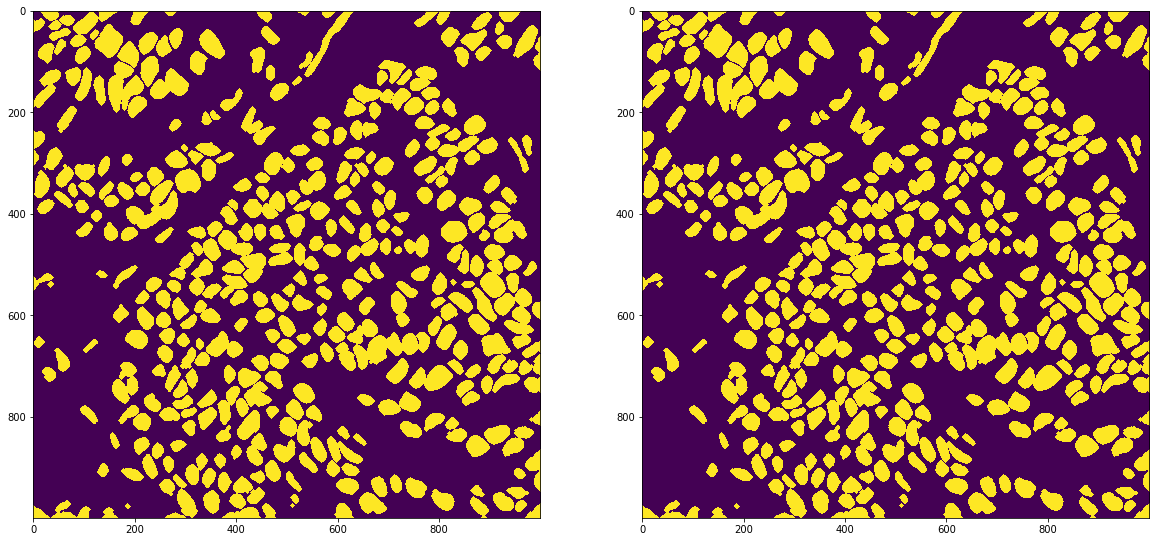

In [19]:
result = ndimage.morphology.binary_dilation(result, iterations=1)
fig,ax = plt.subplots(1,2,figsize=(20,20))
ax[0].imshow(result)
ax[1].imshow(result)

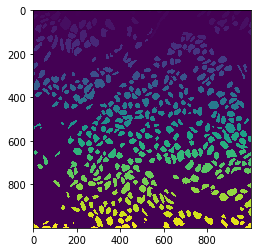

In [14]:
from skimage.morphology import label
lab_img = label(result, connectivity=1)
plt.imshow(lab_img)
plt.show()

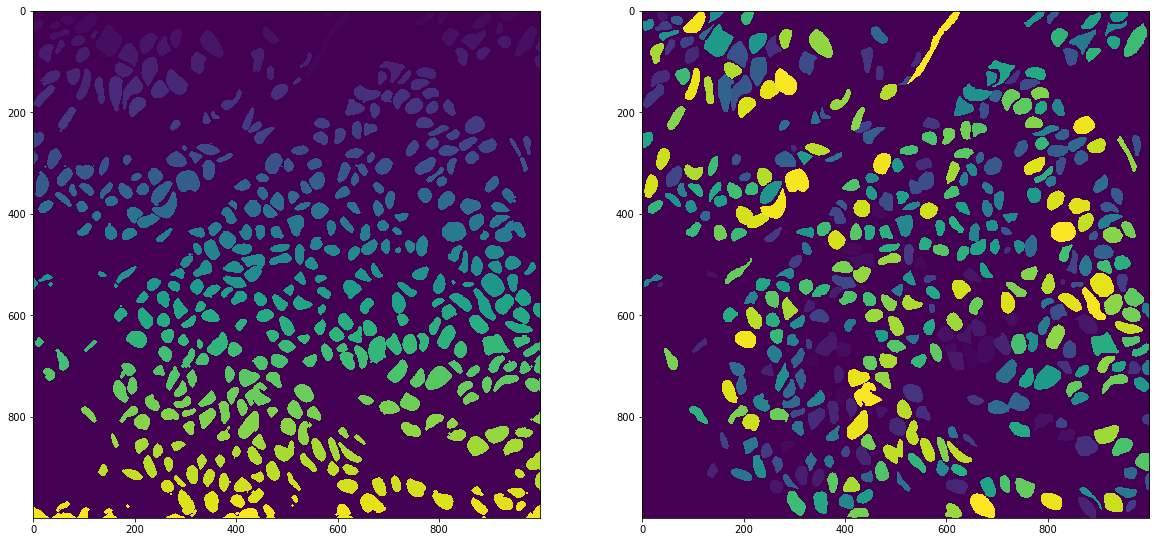

In [16]:

gt7Path = '../dataset/kumar/kumar/train/Labels/TCGA-AR-A1AS-01Z-00-DX1.mat'
gt7LabelFile = scio.loadmat(gt7Path)
gt7Label = gt7LabelFile['inst_map']

fig,ax = plt.subplots(1,2,figsize=(20,20))
ax[0].imshow(lab_img)
ax[1].imshow(gt7Label)





In [18]:
aji = get_fast_aji(remap_label(lab_img),remap_label(gt7Label))
print(aji)


0.7975616726639733
